# Visualization of clustering approaches

Before we begin, let's take a look at the visualization of two main approaches to clustering:
- [partition-based methods](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)
- [density-based methods](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

## Distance metrics

A metric is a function $d(x,y)$ which fulfills the following conditions:
- symmetry: $d(x,y) = d(y,x)$
- identity: $d(x,x) = 0$
- triangle inequality: $d(x,z) \leq d(x,y) + d(y,z)$

There are numerous distance metrics in use in data mining. Some of the most popular include:
- Euclidean: $d(x,y) = \sqrt{\sum\limits_{i=1}^n (x_i^2 - y_i^2)}$
- Manhattan (cityblock): $d(x,y) = \sum\limits_{i=1}^n |x_i - y_i|$
- Chebyshev (chessboard):  $d(x,y) = \max_i|x_i - y_i|$
- Canberra (ranked list): $d(x,y) = \sum\limits_{i=1}^n \frac{|x_i - y_i|}{|x_i|+|y_i|}$

An entire family of metrics is defined as Minkowski distances: $d(x,y,p) = \sum\limits_{i=1}^n (x_i^p - y_i^p)^{\frac{1}{p}}$

# AHC: Agglomerative Hierarchical Clustering

In AHC objects are automatically inserted into a taxonomy based on pairwise distances between objects. Given a numerical representation of text paragraphs it is possible to generate taxonomies, assign paragraphs to correct nodes in the taxonomy, to compare two taxonomies, etc.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_table("zoo.tab")

df.head()

,name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,mammal


In [2]:
df.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000


In [3]:
# transform DataFrame to a NumPy matrix
ndf = df.iloc[:, 1:-1].to_numpy()

ndf

array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0]])

The code below creates a hierarchical clustering model based on two parameters: 

  * __linkage__ defines the way the distance between two clusters is computed
  * __metric__ defines the way the distance between two points is computed
  
Possible values for __linkage__ are: *single*, *complete*, *average*, *weighted*, *centroid*, *ward*, for definitions of these methods [see the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)

Possible values for __metric__ include, among others: *euclidean*, *cityblock*, *minkowski*, *cosine*, *hamming*. The full list with definitions can be found [in the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)

Run the example below and then try to find the best combination of these parameters, i.e., the combination which produces the hierarchy which is the most similar to our biological understanding of the tree of life.

In [4]:
%matplotlib inline

from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'ward']
metrics = ['euclidean', 'cityblock', 'minkowski', 'cosine', 'hamming']

combinations = []
for method in linkage_methods:
    for metric in metrics:
        try:
            model = linkage(ndf, method=method, metric=metric)
            combinations.append((method, metric))
        except:
            pass

labels = df.type.str[0].values

fig, ax = plt.subplots(figsize=(10, 5))

def update(frame):
    method, metric = combinations[frame]
    model = linkage(ndf, method=method, metric=metric)
    ax.clear()
    dendrogram(model, labels=labels, orientation='bottom', leaf_font_size=5, ax=ax)
    ax.set_title(f'Dendrogram using {method.upper()} linkage and {metric.upper()} metric')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Sample')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(combinations), repeat=True)
plt.close(fig)
ani

### Exercise

Experiment with different ways to merge clusters and with different distance metric. Each time visually inspect the resulting dendrogram. Try to identify *the worst* cluster merging criterion for this dataset

In [5]:
# best:  single + euclidean
# worst: single + cityblock

# K-Means Clustering

K-means clustering produces the partitioning of the space into [Voronoi cells](http://alexbeutel.com/webgl/voronoi.html).

The code below illustrates the use of k-means to cluster numerical points. When running the code experiment with varying the number of true clusters generated and the expected number of clusters. See what happens when

  * expected number of clusters is smaller/greater than the true number of clusters
  * the true number of clusters is small vs large

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

true_number_of_clusters = 15

# generate an artificial dataset
X, y = make_blobs(n_samples=1000, n_features=3, centers=true_number_of_clusters, random_state=17)

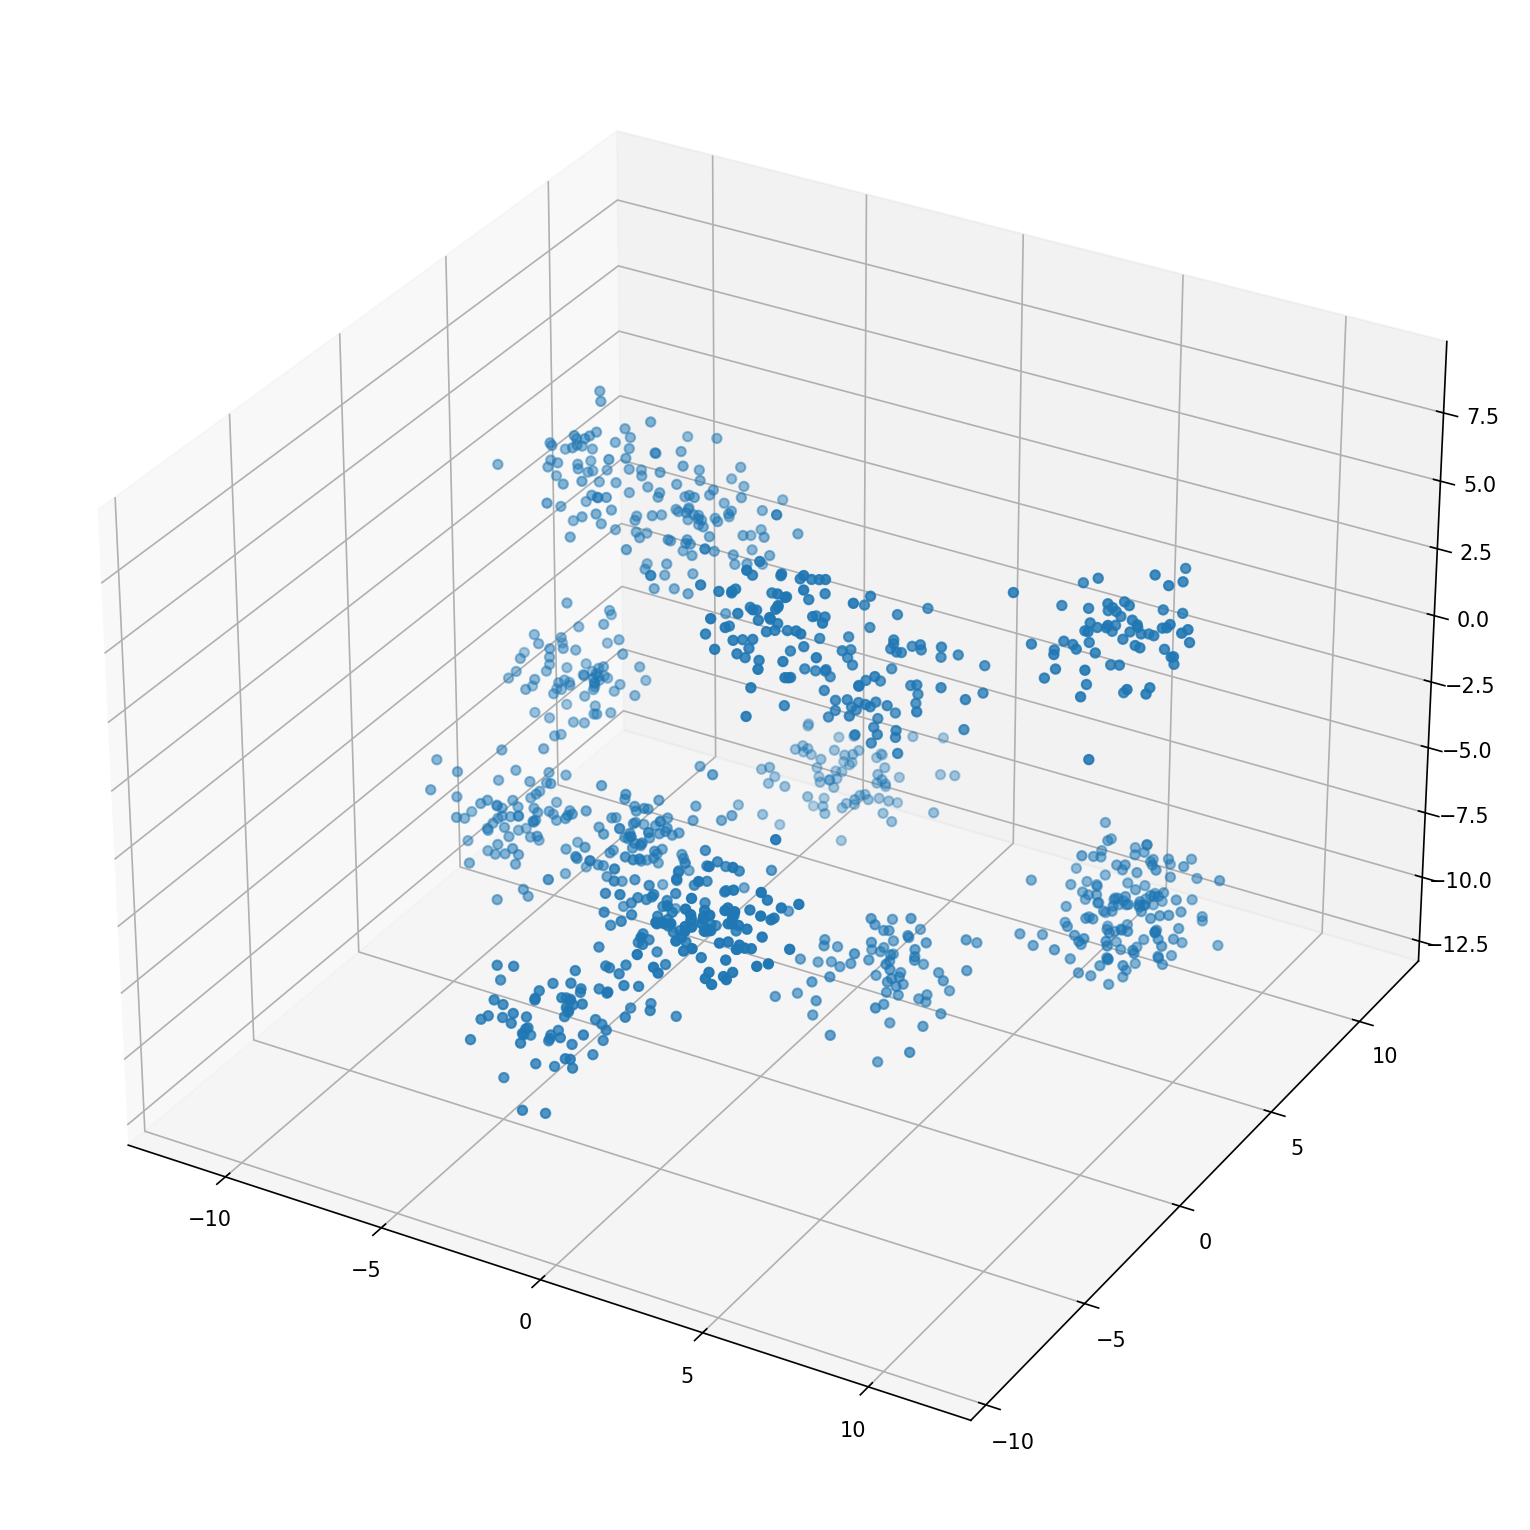

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], X[:, 2]);

In [8]:
model = KMeans(n_clusters=9, n_init=10)
model.fit(X)

# assign points to clusters
labels = model.predict(X)

# print the coordinates of centroids
print(model.cluster_centers_)

labels[:10]

[[-2.86020706  8.93015289 -8.72665566]
 [ 2.20212322 -0.47661988  3.89093611]
 [-7.28783325  6.0920765   2.09939146]
 [ 7.46168065  6.7300133  -8.73960107]
 [-1.07497766 -5.65269358 -5.32027388]
 [-7.1486878   1.97894584 -5.75317887]
 [ 9.00997544  3.01451021  4.36567562]
 [ 3.54770493 -7.67151804 -1.15782779]
 [ 2.88777697  1.4018626  -8.96196937]]


array([6, 1, 4, 4, 5, 1, 3, 7, 1, 2], dtype=int32)

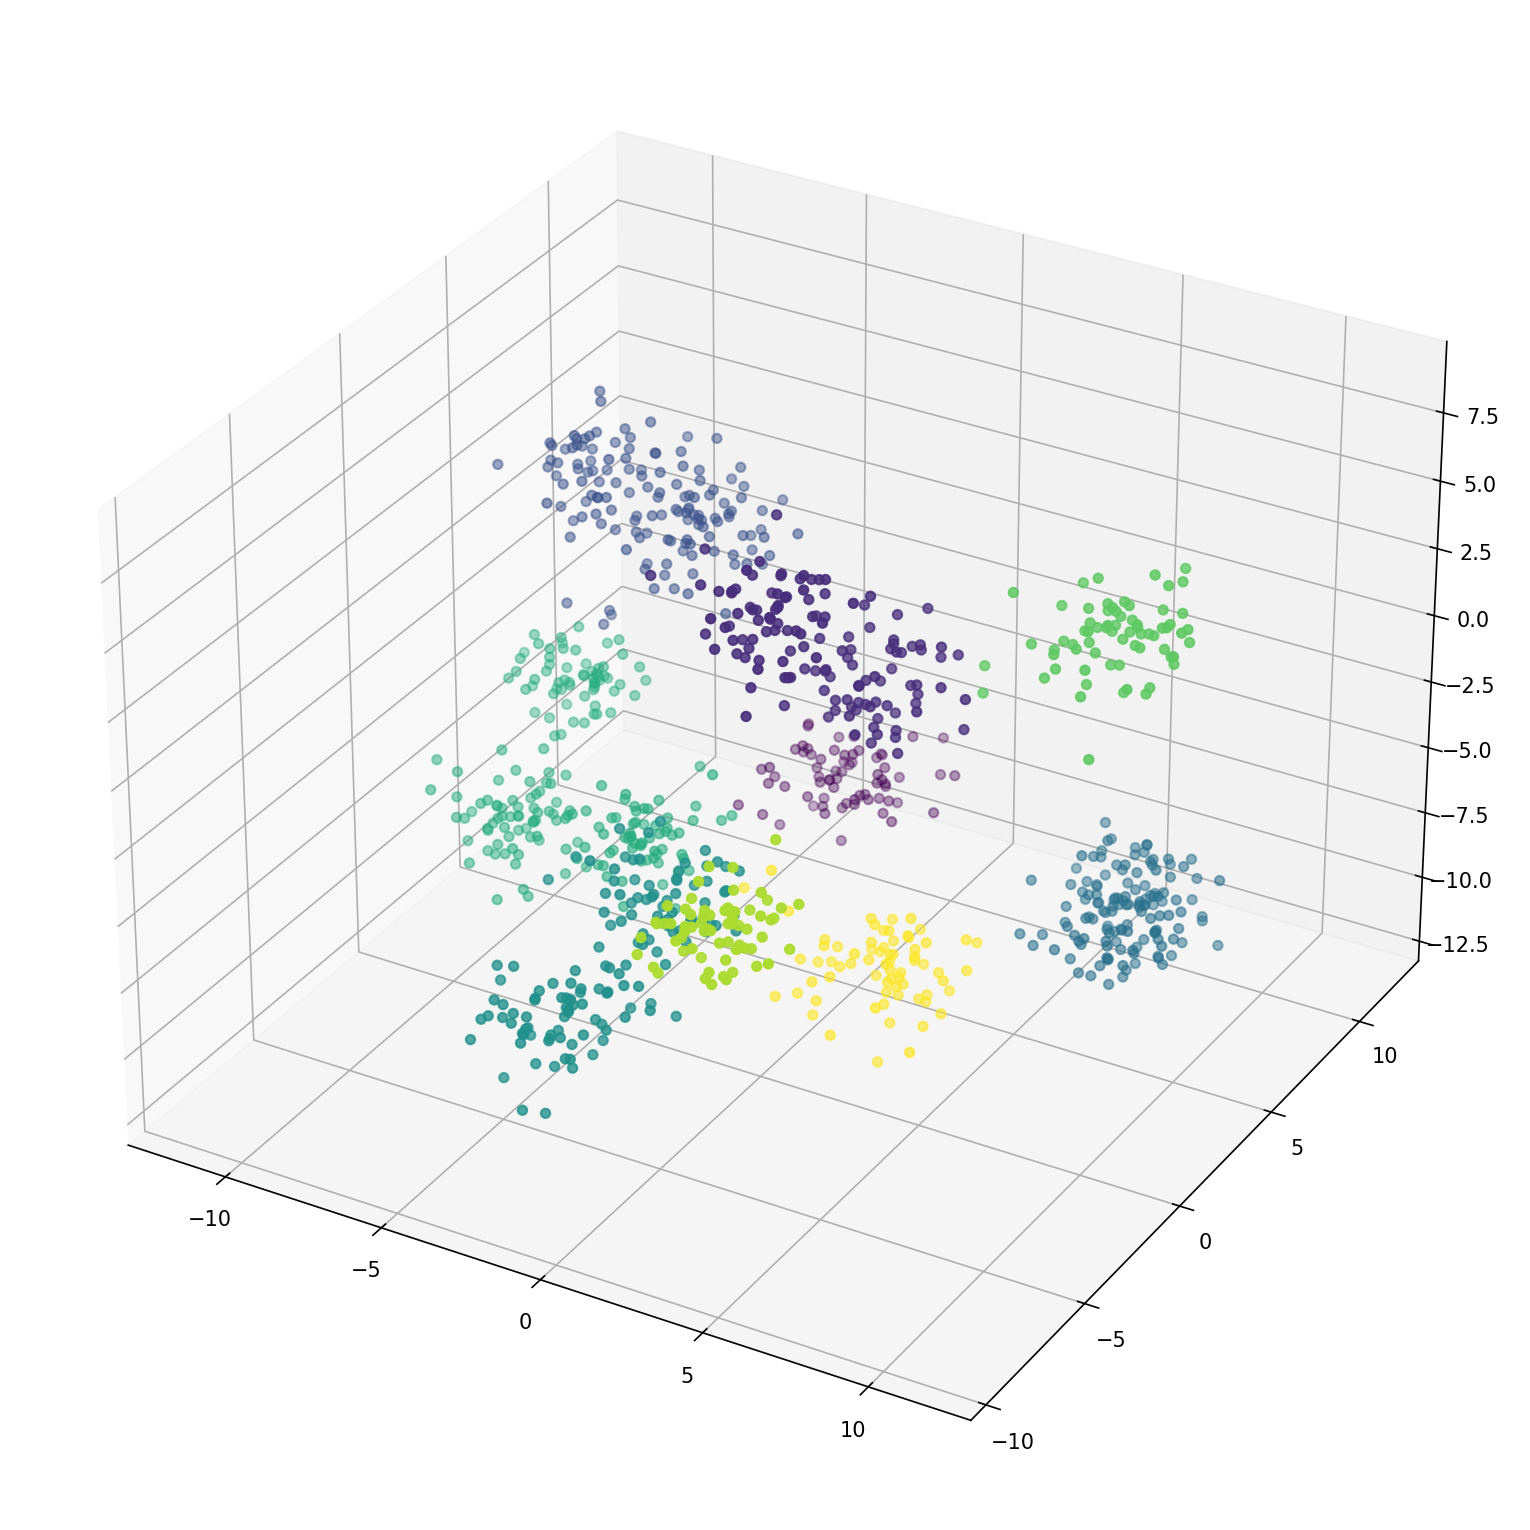

In [9]:
fig = plt.figure(figsize=(10,10))

ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels);

As you can see, guessing the right number of clusters is important. Below we will experiment with different settings of the number of cluster and try to deduce the best using [the Silhouette score](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

  0%|          | 0/18 [00:00<?, ?it/s]

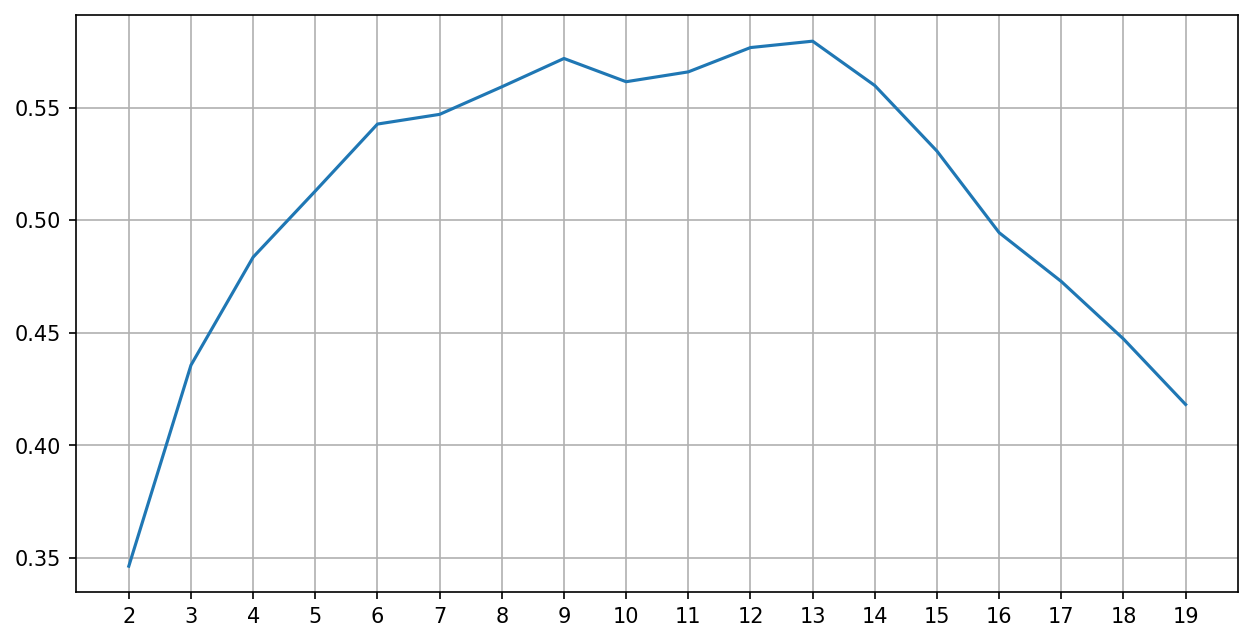

In [10]:
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

k_range = range(2,20)

scores = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=17)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels, metric='euclidean', random_state=17)
    scores.append((k, score))

ax_x, ax_y = zip(*scores)

fig = plt.figure(figsize=(10,5))
ax = plt.axes()
plt.xticks(k_range)
plt.grid()
plt.plot(ax_x, ax_y)

  0%|          | 0/18 [00:00<?, ?it/s]

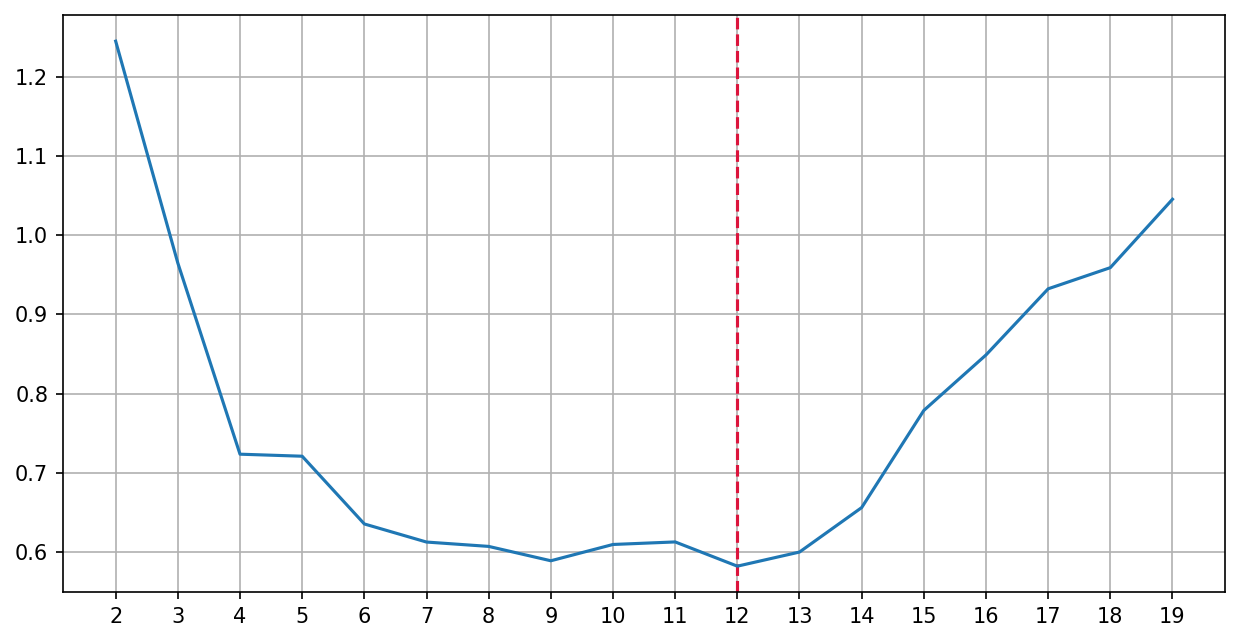

In [11]:
from sklearn.metrics import davies_bouldin_score

k_range = range(2,20)

scores = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=17)
    labels = kmeans.fit_predict(X)
    score = davies_bouldin_score(X, labels)
    scores.append((k, score))

ax_x, ax_y = zip(*scores)
best_n = min(scores, key=lambda x: x[1])

fig = plt.figure(figsize=(10,5))
ax = plt.axes()
plt.xticks(k_range)
plt.axvline(best_n[0], linestyle='--', color='crimson')
plt.grid()
plt.plot(ax_x, ax_y)

### Exercise

Read about the Davies-Bouldin index [here](https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index) and [here](https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index). Repeat the experiment with the discovery of the optimal number of clusters for k-Means, this time using DB-index as the optimization criterion.

# Clustering of text documents

## Word embeddings

The main idea is to represent a word as a vector in an $n$ dimensional space (usually $n=300$), in such a way that the proximity of words in this latent vector space indicates semantic proximity of words. So, this representation not only puts synonyms close to each other, it also puts words that are semantically related quite close to each other.

In order to run this code you have to install SpaCy and download precomputed word embeddings:

```bash
bash$ pip install -U spacy
bash$ python -m spacy download en_core_web_md

```

In [12]:
import spacy

nlp = spacy.load('en_core_web_md')

Words in Spacy have vector representations computed using GloVe (Global Vectors for Word Representation), a method of unsupervised vector computation trained on Wikipedia, Twitter and Common Crawl.

In [13]:
king = nlp('king')
print(king.vector)

[-1.1296e-01 -4.1865e+00 -1.8453e+00  3.0781e-01  2.4956e+00  9.6267e-01
 -1.8161e+00  4.4655e+00 -2.8210e+00  9.7090e-01  1.3542e+01  4.3195e-01
 -5.3098e+00  4.7098e+00  2.9030e+00  1.5588e+00  6.0064e+00 -3.0345e+00
  1.0626e+00 -7.7197e-01 -5.4771e+00 -9.7380e-01 -4.4345e+00  5.8367e+00
  2.4302e+00 -3.9408e+00 -9.1862e-01 -4.9124e+00  1.4591e+00 -7.2772e-01
  3.4957e+00 -4.0077e+00 -1.8354e+00 -4.1052e+00  4.9211e+00 -9.7053e-01
  1.9223e+00  5.2605e+00  1.6086e+00  7.1328e-01 -1.2146e+00 -1.9869e+00
  8.0265e-01  2.9298e+00  7.2985e-01 -6.2892e-01 -1.7082e+00  1.9893e+00
  4.7529e-01  3.2264e+00 -3.9215e+00  4.6556e+00  1.3475e+00 -1.0979e+00
 -3.0365e+00  1.5815e+00  2.2835e+00 -4.0616e+00  2.5730e+00  4.0618e+00
  9.5438e-01 -6.2563e+00  5.6463e+00 -3.8933e+00  4.4076e+00  2.0517e+00
 -6.6906e+00 -6.9448e+00  6.0371e+00  9.3081e-01  1.5180e+00  2.3974e+00
 -3.8043e+00 -4.3941e+00 -3.6979e+00  2.9489e+00 -8.9735e+00  9.5273e+00
 -6.4149e-01  2.2565e+00 -7.2062e+00 -1.0078e+00 -4

In [14]:
words = ['king','queen','kingdom','emperor','spades','Lear','milk']
    
for word in words:
    print(f"{king} {word} \t {king.similarity(nlp(word))} ")

king king 	 1.0 
king queen 	 0.6108841628588695 
king kingdom 	 0.7228067266887807 
king emperor 	 0.6999850873799717 
king spades 	 0.18366566786736255 
king Lear 	 0.17662365792564294 
king milk 	 0.10963522563659008 


To see the clustering in action let us import a text document and try to find clusters the document

In [15]:
from bs4 import BeautifulSoup
import requests

respond = requests.get("https://en.wikipedia.org/wiki/Poznań")
soup = BeautifulSoup(respond.text, "html")
page = soup.find_all('p')

raw_text = ''.join([paragraph.text for paragraph in page])

print(raw_text[:1000])


Poznań (Polish: [ˈpɔznaɲ] ⓘ)[a] is a city on the River Warta in west Poland, within the Greater Poland region. The city is an important cultural and business centre, and one of Poland's most populous regions with many regional customs such as Saint John's Fair (Jarmark Świętojański), traditional Saint Martin's croissants and a local dialect. Among its most important heritage sites are the Renaissance Old Town, Town Hall and Gothic Cathedral.
Poznań is the fifth-largest and one of the oldest cities in Poland. As of 2023, the city's population is 540,146, while the Poznań metropolitan area (Metropolia Poznań) comprising Poznań County and several other communities is inhabited by over 1.029 million people.[2] It is one of four historical capitals of medieval Poland and the ancient capital of the Greater Poland region, currently the administrative capital of the province called Greater Poland Voivodeship.
Poznań is a centre of trade, sport, education, technology and tourism. It is an impo

First, we will use the traditional vector space model, where each phrase will be represented as the vector of words appearing in this phrase. We will use the TF-IDF weighting of words and some stop-word removal

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

phrases = raw_text.replace('\n','').split('.')
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(phrases)

print('\nVocabulary')
print(vectorizer.get_feature_names_out())

print('\nList of stopwords')
print(vectorizer.get_stop_words())

print('\nDocument in the vector space')
print(X.todense())


Vocabulary
['000' '029' '04' ... 'żabka' 'ˈpɔznaɲ' 'ױזן']

List of stopwords
frozenset({'above', 'for', 'across', 'rather', 'about', 'itself', 'four', 'become', 'thick', 'an', 'their', 'yourself', 'may', 'whence', 'down', 'seeming', 'together', 'latter', 'fire', 'whoever', 'ten', 'keep', 'everyone', 'could', 'fill', 'ourselves', 'we', 'when', 'his', 'moreover', 'whereupon', 'anyone', 'by', 'were', 'de', 'often', 'those', 'mine', 'con', 'thence', 're', 'here', 'has', 'side', 'sometime', 'beyond', 'whether', 'during', 'eight', 'around', 'more', 'ours', 'perhaps', 'hereby', 'hasnt', 'besides', 'onto', 'somewhere', 'many', 'became', 'sixty', 'between', 'three', 'these', 'empty', 'system', 'whereafter', 'as', 'done', 'whereby', 'is', 'our', 'becoming', 'again', 'either', 'being', 'go', 'former', 'co', 'becomes', 'same', 'other', 'after', 'hers', 'have', 'they', 'beside', 'without', 'yourselves', 'themselves', 'whole', 'she', 'from', 'had', 'cannot', 'otherwise', 'mill', 'if', 'the', 'every

In [17]:
X.shape

(316, 1807)

First, let us verify how efficient is simple k-Means when applied to the simple TF-IDF document representation.

In [18]:
from tqdm.notebook import tqdm

true_k = 10
num_words = 5

model = KMeans(n_clusters=true_k, max_iter=1000)
model.fit(X)

centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in tqdm(range(true_k)):
    print (f'Cluster {i}: {[terms[j] for j in centroids[i, :num_words]]}')

/home/drew/prog/venvs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/10 [00:00<?, ?it/s]

Cluster 0: ['warta', 'river', 'main', 'stadium', 'cybina']
Cluster 1: ['polish', 'voivodeship', 'poznań', 'seat', 'city']
Cluster 2: ['town', 'buildings', 'st', 'including', 'old']
Cluster 3: ['city', 'north', 'people', 'west', 'centre']
Cluster 4: ['german', 'number', 'population', '000', 'period']
Cluster 5: ['inhabitants', 'poland', 'region', 'poznań', 'greater']
Cluster 6: ['martin', 'saint', 'regional', 'patron', 'święty']
Cluster 7: ['poznań', 'city', 'club', 'football', 'centre']
Cluster 8: ['university', 'universities', 'poznań', 'mickiewicz', 'institutions']
Cluster 9: ['poland', 'largest', 'poznań', 'city', 'oldest']


As the next step, we will create an embedding for each sentence. The embedding of a sentence will be the average of word vectors for each word appearing in the sentence.

In [19]:
raw_text = raw_text.replace(',', ' ').replace('(', ' ').replace(')', ' ').replace('\n','').replace('.',' .')

In [20]:
words = {
    word.lower(): nlp(word).vector
    for word in set(raw_text.split())
    if np.any(nlp(word).vector)
}

To avoid "bad embeddings" we will use only the sentences which contain at least 5 words.

In [21]:
X = np.vstack(
    [
        np.mean([words[w] for w in phrase if w in words], axis=0) 
        for phrase in phrases 
        if len(phrase.split()) >= 5
    ]
)

In [22]:
X.shape

(302, 300)

As we see, the number of sentences is similar (284) and each sentence is represented as a 300-dimensional vector.

Our next step is to run `DBSCAN` algorithm on these sentences.

In [23]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.3, min_samples=3)
model.fit(X)

DBSCAN(eps=0.3, min_samples=3)

Let us see the labels assigned to each sentence. The value -1 denotes a sentence which is an outlier (it is not the part of any cluster)

In [24]:
model.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [25]:
for cluster_id in np.unique(model.labels_):
    if cluster_id >= 0:
        print(f"Cluster {cluster_id}")
        print([phrases[i] for i in np.where(model.labels_ == cluster_id)[0]])

Finally, let us see how `DBSCAN` handles the word embeddings. This time, we will skip the information about the sentences, the clustering model will be computed directly from the word embeddings.

In [26]:
X = np.vstack(list(words.values()))
X.shape

(1955, 300)

In [27]:
model = DBSCAN(eps=0.15, min_samples=3)
model.fit(X)

DBSCAN(eps=0.15, min_samples=3)

In [28]:
for cluster_id in np.unique(model.labels_):
    if cluster_id >= 0:
        print(f"Cluster {cluster_id}")
        print([list(words.keys())[i] for i in np.where(model.labels_ == cluster_id)[0]])

Cluster 0
['532', '261', '306', '274', '515', '696', '1038', '1005', '321', '387']
Cluster 1
['.[17]', '.[8]', '.[14]', '.[23]', '.[52]', '.[11][12]', '.[62]', 'bzyk[48]', '.[18]', '.[7]', '.[53]', '.[2]', '.[13]', '000[24]', '.[55][56]', '.[28]', '.[22]', '.[60][61]', '.[59]', 'with:[69][70]', '.[43][44]', '.[6]', '.[19]', '.[64]']
Cluster 2
['1039', '1012', '980']
Cluster 3
['bretislaus', '1253', '1247', 'boleslaus', 'mieszko', '1249', '1244']
Cluster 4
['ostrówek', 'wielkopolski', 'nowe', 'kks', 'miasto', 'wągrowiec', 'grodzisk', 'azs', 'wielki', 'ostrów', 'nowy']
Cluster 5
['bolesław', 'poznan', 'polski', 'tychy', 'warsaw', 'białystok', 'bydgoszcz', 'warta', 'łódź', 'kraków', 'cegielski', 'armia', 'zamek', 'wrocław', 'lech', 'główna', 'katowice', 'główny', 'powszechna', 'przemysł', 'poznań', 'gniezno']
Cluster 6
['1236', 'ad', 'urbe', '1146']
Cluster 7
['duchies', 'suchy', 'duchy', 'piast']
Cluster 8
['humid', 'köppen', 'cfb', 'dfb']
Cluster 9
['warta"', '"warta', 'poznań"']
Cluste

### Exercise

Change the clustering algorithm to `k-Means` and use one of the optimization criteria (either the silhouette index or the Davies-Bouldin index) to find the "right" number of clusters.

In [29]:
max_clusters = 100

In [30]:
k_range = range(2, max_clusters)

scores = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=17)
    labels = kmeans.fit_predict(X)
    score = davies_bouldin_score(X, labels)
    scores.append((k, score))

  0%|          | 0/98 [00:00<?, ?it/s]

In [35]:
import plotly.graph_objects as go

ax_x, ax_y = zip(*scores)
best_n = min(scores, key=lambda x: x[1])

# Port to Plotly
fig = go.Figure()

# Line plot
fig.add_trace(go.Scatter(x=ax_x, y=ax_y, mode='lines', name='Line Plot'))

# Vertical line
fig.add_vline(x=best_n[0], line=dict(dash='dash', color='crimson'))

# Update layout
fig.update_layout(
    xaxis_title='Number of clusters',
    yaxis_title='Davies bouldin score',
    title='Performance by number of clusters',
    width=1000,
    height=500,
    showlegend=False
)

fig.show()